Modules found on network:
S5-3 | S-0038
S5-3 | S-0009
S5-3 | S-0033
S5-3 | S-0025
S5-3 | S-0036
S5-3 | S-0016
Teach-In Started...
Recording...
Recording done.
Recorded 918 samples.


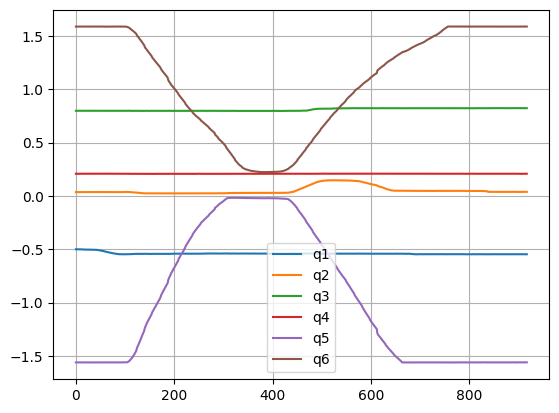

Replay Started...
Finished Replay.
Program Finished.


In [2]:
import hebi
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt

# Initialize HEBI Lookup
lookup = hebi.Lookup()
sleep(2)  # Allow time to discover modules

print('Modules found on network:')
for entry in lookup.entrylist:
    print(f'{entry.family} | {entry.name}')
    
# Initialize group
group = lookup.get_group_from_names(['S5-3'], ['S-0038', 'S-0009', 'S-0033', 'S-0025', 'S-0036', 'S-0016'])
if group is None:
    raise RuntimeError("Group could not be found!")


# Command settings
group_command = hebi.GroupCommand(group.size)
group_feedback = hebi.GroupFeedback(group.size)

# Define parameters
frequency = 100  # Hz
recording_time = 10  # seconds
time_step = 1 / frequency  # time step based on frequency

# Preallocate Q for position data
Q = np.zeros((int(recording_time * frequency), group.size))
row = 0

# Record trajectory
print('Teach-In Started...')
print('Recording...')
start_time = time()
while (time() - start_time) < recording_time:
    # Get feedback
    group.get_next_feedback(reuse_fbk=group_feedback)
    Q[row, :] = group_feedback.position
    row += 1
    
    # Send zero effort command
    group_command.effort = np.zeros(group.size)
    group.send_command(group_command)
    
    # Sleep for the rest of the time step
    sleep(time_step)

print('Recording done.')
print(f'Recorded {row} samples.')

# Trim Q to remove unused rows
Q = Q[:row, :]

# Plot the trajectory
plt.plot(Q)
plt.legend([f'q{i+1}' for i in range(group.size)])
plt.grid(True)
plt.show()

# Pause before playback
sleep(5)
print('Replay Started...')

# Replay recorded trajectory in reverse
for i in range(row-1, -1, -1):
    group_command.position = Q[i, :]
    group.send_command(group_command)
    sleep(time_step)

print('Finished Replay.')

# Reset and finalize
print('Program Finished.')


In [3]:
# Example joint angle data (replace with real data if available)

def hebi_transformed_matrix(link_length, theta):
    return np.array([[0, -np.cos(theta), np.sin(theta), link_length * np.sin(theta)],
                     [1, 0, 0, 0],
                     [0, np.sin(theta), np.cos(theta), link_length * np.cos(theta)],
                     [0, 0, 0, 1]])


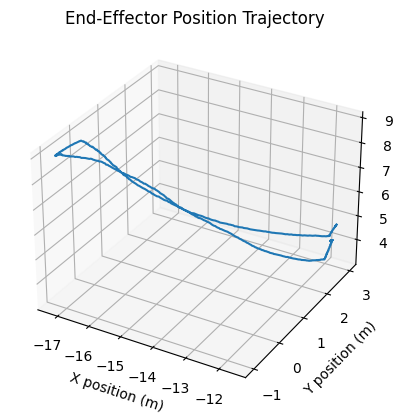

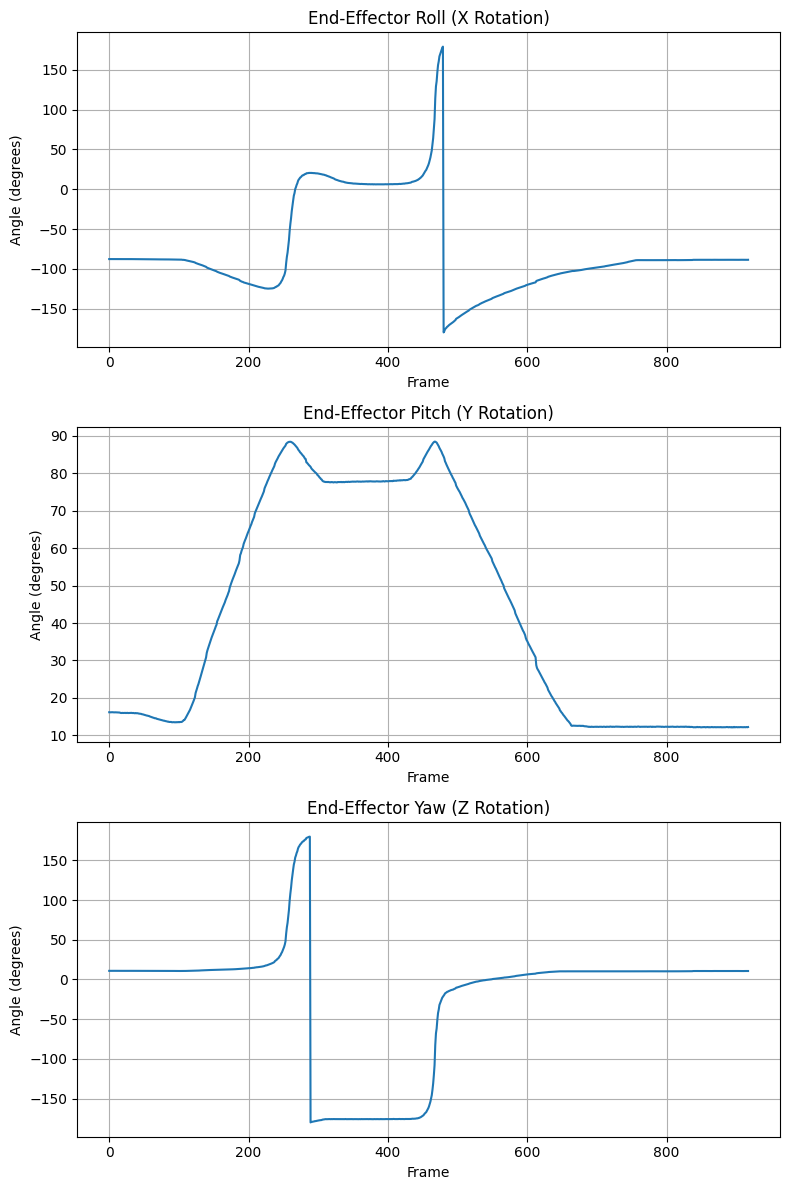

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# リンクの長さ
link_length = 3.5  # メートル単位

# 各リンクの変換行列を計算する関数
def hebi_transformed_matrix(length, theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([
        [0, -c, s, length * s],
        [1,  0, 0, 0],
        [0,  s, c, length * c],
        [0,  0, 0, 1]
    ])

# エンドエフェクタの位置とオリエンテーション（オイラー角）を保存するリスト
end_effector_positions = []
end_effector_orientations = []

# 各フレームのエンドエフェクタ位置と回転を計算
for joint_angles in Q:
    # 各ジョイントの角度を取得
    theta1, theta2, theta3, theta4, theta5, theta6 = joint_angles
    
    # 各リンクの変換行列を計算
    T12 = hebi_transformed_matrix(link_length, theta1)
    T23 = hebi_transformed_matrix(link_length, theta2)
    T34 = hebi_transformed_matrix(link_length, theta3)
    T45 = hebi_transformed_matrix(link_length, theta4)
    T56 = hebi_transformed_matrix(link_length, theta5)
    T6e = hebi_transformed_matrix(link_length, theta6)
    
    # 基準座標からエンドエフェクタまでの総合変換行列を計算
    T0e = T12 @ T23 @ T34 @ T45 @ T56 @ T6e
    
    # エンドエフェクタの位置（x, y, z）を抽出
    end_effector_position = T0e[:3, 3]
    end_effector_positions.append(end_effector_position)
    
    # エンドエフェクタの回転行列をオイラー角に変換して保存
    rotation_matrix = T0e[:3, :3]
    r = R.from_matrix(rotation_matrix)
    euler_angles = r.as_euler('xyz', degrees=True)  # オイラー角（XYZ順、度数法）
    end_effector_orientations.append(euler_angles)

# numpy配列に変換
end_effector_positions = np.array(end_effector_positions)
end_effector_orientations = np.array(end_effector_orientations)

# エンドエフェクタの軌跡（位置）を3Dプロット
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(end_effector_positions[:, 0], end_effector_positions[:, 1], end_effector_positions[:, 2])
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')
ax.set_title("End-Effector Position Trajectory")
plt.show()

# エンドエフェクタの回転（オイラー角）をプロット
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))

# X軸回転（ロール）
ax1.plot(end_effector_orientations[:, 0])
ax1.set_title("End-Effector Roll (X Rotation)")
ax1.set_xlabel("Frame")
ax1.set_ylabel("Angle (degrees)")
ax1.grid(True)

# Y軸回転（ピッチ）
ax2.plot(end_effector_orientations[:, 1])
ax2.set_title("End-Effector Pitch (Y Rotation)")
ax2.set_xlabel("Frame")
ax2.set_ylabel("Angle (degrees)")
ax2.grid(True)

# Z軸回転（ヨー）
ax3.plot(end_effector_orientations[:, 2])
ax3.set_title("End-Effector Yaw (Z Rotation)")
ax3.set_xlabel("Frame")
ax3.set_ylabel("Angle (degrees)")
ax3.grid(True)

plt.tight_layout()
plt.show()


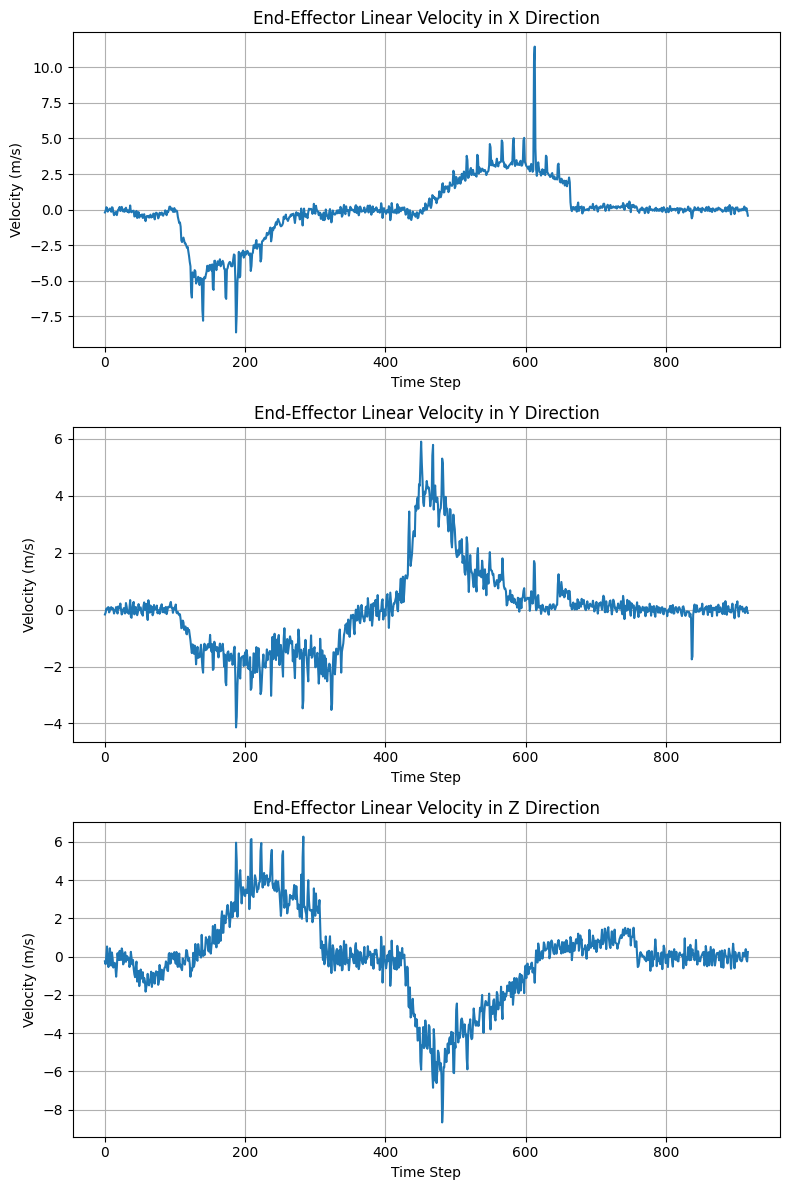

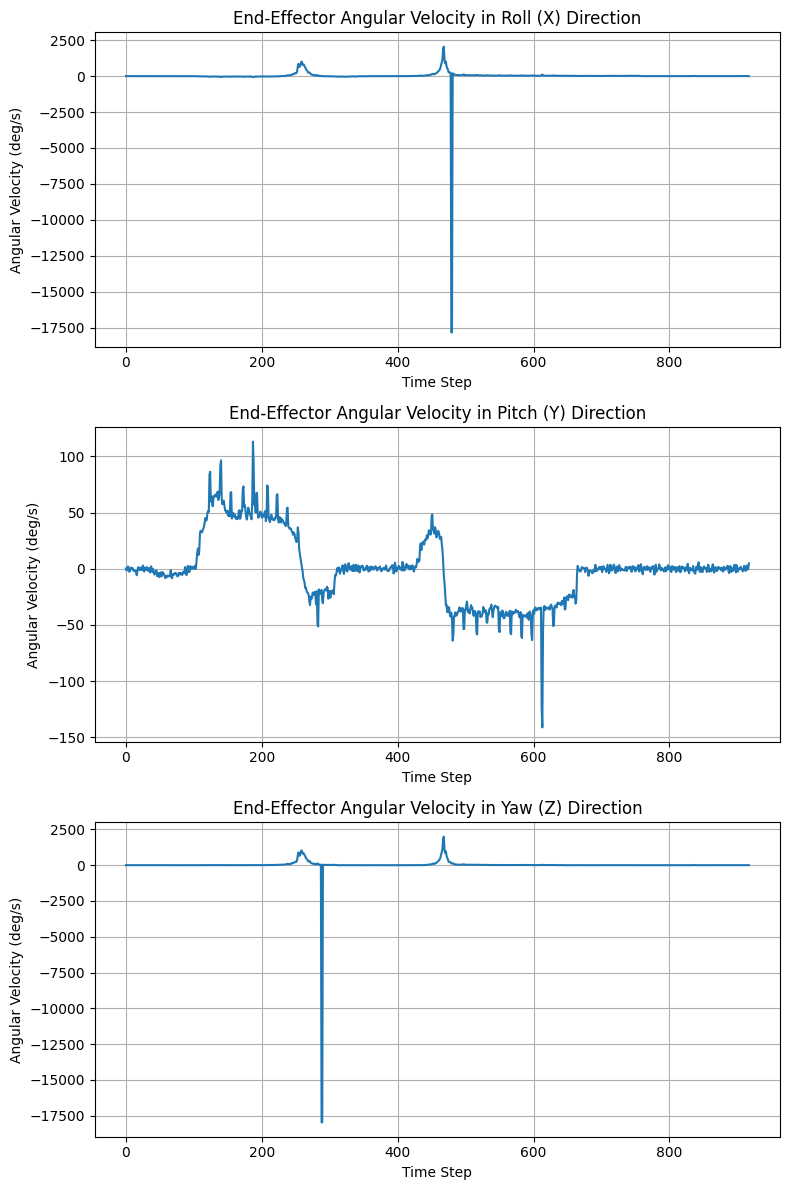

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# サンプリング周波数
frequency = 100  # Hz
time_step = 1 / frequency  # サンプリング周期

# 位置データから線速度を計算（中央差分）
velocities = (end_effector_positions[2:] - end_effector_positions[:-2]) / (2 * time_step)

# 始点と終点の線速度は一次差分で計算
velocities = np.vstack((
    (end_effector_positions[1] - end_effector_positions[0]) / time_step,
    velocities,
    (end_effector_positions[-1] - end_effector_positions[-2]) / time_step
))

# オイラー角から角速度を計算（中央差分）
angular_velocities = (end_effector_orientations[2:] - end_effector_orientations[:-2]) / (2 * time_step)

# 始点と終点の角速度は一次差分で計算
angular_velocities = np.vstack((
    (end_effector_orientations[1] - end_effector_orientations[0]) / time_step,
    angular_velocities,
    (end_effector_orientations[-1] - end_effector_orientations[-2]) / time_step
))

# 位置の線速度の軌跡をプロット
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))

# X方向の線速度
ax1.plot(velocities[:, 0])
ax1.set_title("End-Effector Linear Velocity in X Direction")
ax1.set_xlabel("Time Step")
ax1.set_ylabel("Velocity (m/s)")
ax1.grid(True)

# Y方向の線速度
ax2.plot(velocities[:, 1])
ax2.set_title("End-Effector Linear Velocity in Y Direction")
ax2.set_xlabel("Time Step")
ax2.set_ylabel("Velocity (m/s)")
ax2.grid(True)

# Z方向の線速度
ax3.plot(velocities[:, 2])
ax3.set_title("End-Effector Linear Velocity in Z Direction")
ax3.set_xlabel("Time Step")
ax3.set_ylabel("Velocity (m/s)")
ax3.grid(True)

plt.tight_layout()
plt.show()

# 回転の角速度の軌跡をプロット
fig, (ax4, ax5, ax6) = plt.subplots(3, 1, figsize=(8, 12))

# Roll方向の角速度
ax4.plot(angular_velocities[:, 0])
ax4.set_title("End-Effector Angular Velocity in Roll (X) Direction")
ax4.set_xlabel("Time Step")
ax4.set_ylabel("Angular Velocity (deg/s)")
ax4.grid(True)

# Pitch方向の角速度
ax5.plot(angular_velocities[:, 1])
ax5.set_title("End-Effector Angular Velocity in Pitch (Y) Direction")
ax5.set_xlabel("Time Step")
ax5.set_ylabel("Angular Velocity (deg/s)")
ax5.grid(True)

# Yaw方向の角速度
ax6.plot(angular_velocities[:, 2])
ax6.set_title("End-Effector Angular Velocity in Yaw (Z) Direction")
ax6.set_xlabel("Time Step")
ax6.set_ylabel("Angular Velocity (deg/s)")
ax6.grid(True)

plt.tight_layout()
plt.show()


Simulating: 100%|██████████| 800/800 [06:41<00:00,  1.99it/s]


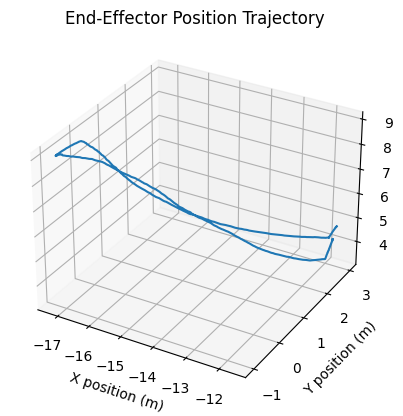

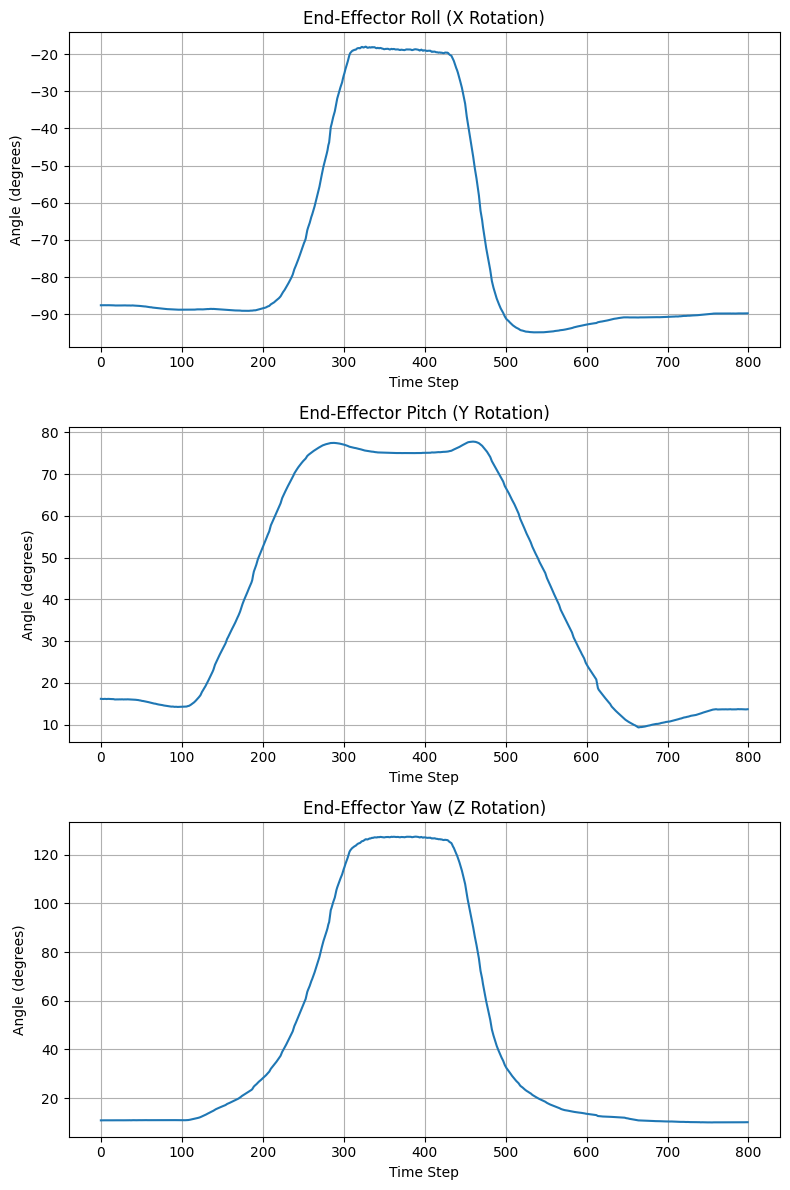

In [10]:
import numpy as np
import sympy as sp
import time
from scipy.linalg import pinv
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm  # tqdmのインポート

# 計測スタート
start_time = time.time()

# 変数の定義
theta1, theta2, theta3, theta4, theta5, theta6 = sp.symbols('theta1 theta2 theta3 theta4 theta5 theta6', real=True)
link_length = sp.symbols('link_length', real=True)

# 変換行列の定義
def hebi_transform(theta):
    return sp.Matrix([
        [0, -sp.cos(theta), sp.sin(theta), link_length * sp.sin(theta)],
        [1, 0, 0, 0],
        [0, sp.sin(theta), sp.cos(theta), link_length * sp.cos(theta)],
        [0, 0, 0, 1]
    ])

# 各リンク間の変換行列
T12 = hebi_transform(theta1)
T23 = hebi_transform(theta2)
T34 = hebi_transform(theta3)
T45 = hebi_transform(theta4)
T56 = hebi_transform(theta5)
T6e = hebi_transform(theta6)

# 全体の変換行列
T0e = T12 * T23 * T34 * T45 * T56 * T6e

# エンドエフェクタの位置と回転行列の抽出
position = T0e[:3, 3]
rotation_matrix = T0e[:3, :3]

# lambdifyで数値的に扱える関数を作成
position_func = sp.lambdify((theta1, theta2, theta3, theta4, theta5, theta6, link_length), position, modules="numpy")
rotation_func = sp.lambdify((theta1, theta2, theta3, theta4, theta5, theta6, link_length), rotation_matrix, modules="numpy")

# パラメータ
params = (3.5,)  # リンクの長さ

# 初期設定
frequency = 100  # サンプリング周波数 (Hz)
time_step = 1 / frequency  # サンプリング周期
joint_angles = [np.array(Q[0])]  # 初期角度
positions = []
orientations = []

# エンドエフェクタの線速度と角速度の目標値
linear_velocity_target = np.array([0.5, 0.5, 0.5])  # m/s
angular_velocity_target = np.array([0.1, 0.1, 0.1])  # deg/s

# tqdmで進捗バーを表示しながらシミュレーション開始
for i in tqdm(range(800), desc="Simulating"):
    current_angles = joint_angles[-1]
    linear_velocity_target = velocities[i]
    angular_velocities_target = angular_velocities[i]
    
    # エンドエフェクタの位置と回転行列を計算
    pos = np.array(position_func(*current_angles, *params), dtype=np.float64)
    rot_mat = np.array(rotation_func(*current_angles, *params), dtype=np.float64)
    
    # 回転行列をオイラー角に変換して保存
    r = R.from_matrix(rot_mat)
    euler_angles = r.as_euler('xyz', degrees=True)
    positions.append(pos)
    orientations.append(euler_angles)
    
    # ヤコビアン行列の数値計算（位置に対するヤコビアン）
    J_pos = position.jacobian([theta1, theta2, theta3, theta4, theta5, theta6])
    J_pos_func = sp.lambdify((theta1, theta2, theta3, theta4, theta5, theta6, link_length), J_pos, modules="numpy")
    J_numeric_pos = np.array(J_pos_func(*current_angles, *params), dtype=np.float64)
    
    # ジョイント角速度を計算（線速度追従）
    joint_velocity_pos = pinv(J_numeric_pos).dot(linear_velocity_target)
    
    # オイラー角のヤコビアン行列を計算（角速度追従用）
    euler_symbols = sp.Matrix([sp.atan2(rotation_matrix[2, 1], rotation_matrix[2, 2]),
                               sp.asin(-rotation_matrix[2, 0]),
                               sp.atan2(rotation_matrix[1, 0], rotation_matrix[0, 0])])
    J_rot = euler_symbols.jacobian([theta1, theta2, theta3, theta4, theta5, theta6])
    J_rot_func = sp.lambdify((theta1, theta2, theta3, theta4, theta5, theta6, link_length), J_rot, modules="numpy")
    J_numeric_rot = np.array(J_rot_func(*current_angles, *params), dtype=np.float64)
    
    # 角速度に対応するジョイント速度の計算
    angular_velocity_rad = np.radians(angular_velocity_target)
    joint_velocity_rot = pinv(J_numeric_rot).dot(angular_velocity_rad)
    
    # 線速度と角速度のジョイント速度の合成
    joint_velocity = joint_velocity_pos + joint_velocity_rot

    # ジョイント角度の更新
    next_joint_angle = current_angles + joint_velocity * time_step
    joint_angles.append(next_joint_angle)

# プロット
positions = np.array(positions)
orientations = np.array(orientations)

# エンドエフェクタの位置をプロット
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2])
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')
ax.set_title("End-Effector Position Trajectory")
plt.show()

# オイラー角のプロット
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))
ax1.plot(orientations[:, 0])
ax1.set_title("End-Effector Roll (X Rotation)")
ax1.set_xlabel("Time Step")
ax1.set_ylabel("Angle (degrees)")
ax1.grid(True)

ax2.plot(orientations[:, 1])
ax2.set_title("End-Effector Pitch (Y Rotation)")
ax2.set_xlabel("Time Step")
ax2.set_ylabel("Angle (degrees)")
ax2.grid(True)

ax3.plot(orientations[:, 2])
ax3.set_title("End-Effector Yaw (Z Rotation)")
ax3.set_xlabel("Time Step")
ax3.set_ylabel("Angle (degrees)")
ax3.grid(True)

plt.tight_layout()
plt.show()


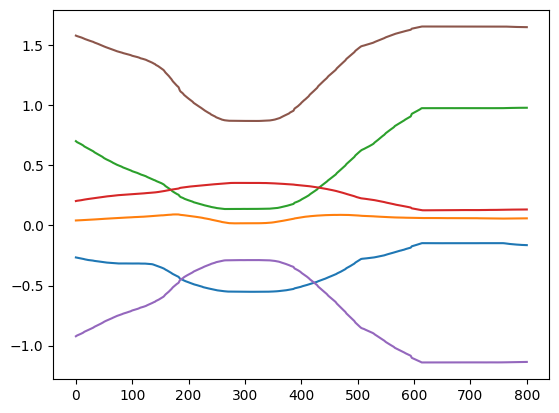

In [44]:
plt.plot(joint_angles)